<a href="https://colab.research.google.com/github/xiaodi-nie/ML-model-on-GKE-with-load-test/blob/master/Titanic_prediction_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [0]:
titanic_test = "https://raw.githubusercontent.com/YummyPancake/Titanic_prediction/master/test.csv"
titanic_train = "https://raw.githubusercontent.com/YummyPancake/Titanic_prediction/master/train.csv"
df_test = pd.read_csv(titanic_test)
df_train = pd.read_csv(titanic_train)

In [71]:
print(df_train.shape)
print(df_test.shape)

(891, 12)
(418, 11)


### Features in the dataset
* Survived: Survived (1) or died (0)
* Pclass: Passenger’s class
* Name: Passenger’s name
* Sex: Passenger’s sex
* Age: Passenger’s age
* SibSp: Number of siblings/spouses 
* aboard
* Parch: Number of parents/children aboard
* Ticket: Ticket number
* Fare: Fare
* Cabin: Cabin
* Embarked: Port of embarkation

In [72]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [73]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [74]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [75]:
# analyze missing values
total = df_train.isnull().sum().sort_values(ascending=False)
percent_1 = df_train.isnull().sum()/df_train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


In [76]:
df_train.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

## Analyze feature contributions
1. 'PassengerId', 'Name', 'Ticket' do not contribute to suvival, can be removed
2. Analyze whether other features contribute to suvival

### Age and sex

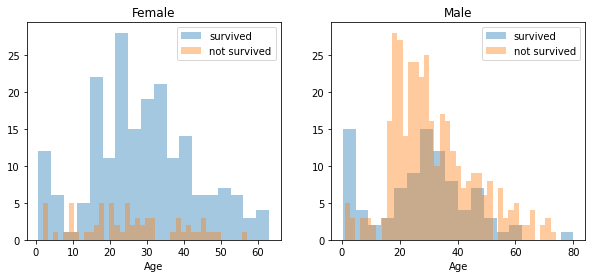

In [77]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = df_train[df_train['Sex']=='female']
men = df_train[df_train['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')




*   Women's suvival chances are higher between 14 and 40; Men's suvival chances are higher between 18 and 30
*   Certain ages and sex increase suvival possibilities
* Ages will be grouped for future classification



### Embarked, Pclass and Sex

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


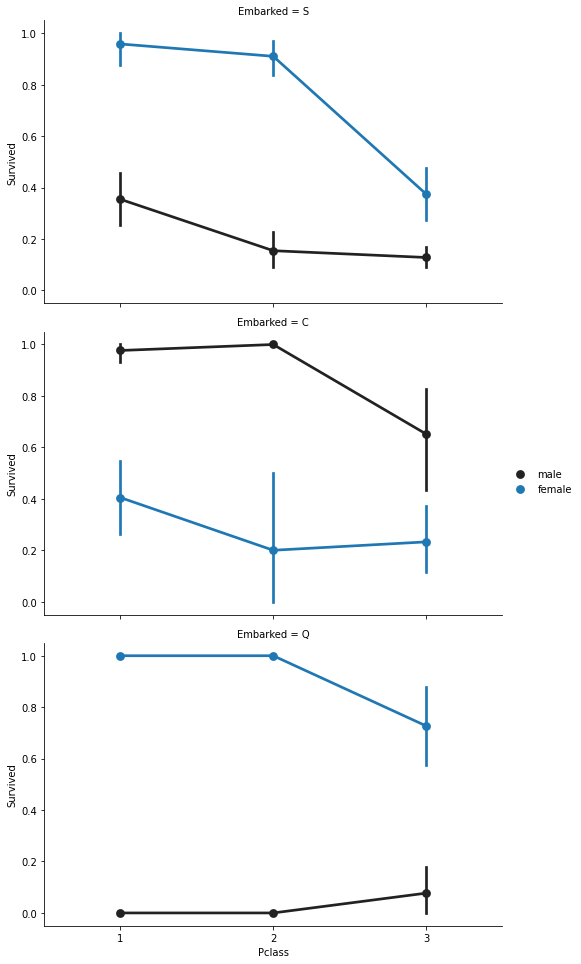

In [78]:
FacetGrid = sns.FacetGrid(df_train, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()



*   Embarked ports seems related to the possibility of survival, depending on genders
*   Women on port Q and port S have a higher suvival chance, while men on port C have a higher suvival chance



### Pclass

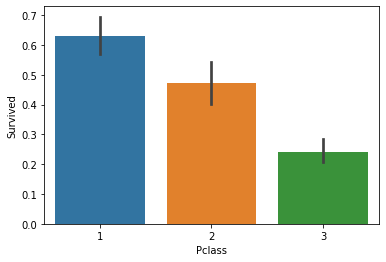

In [79]:
sns.barplot(x='Pclass', y='Survived', data=df_train)



*   Pclass contributes to a person's chance of suvival
*   People in higher classes have higher chance of suvival



### SibSp and Parch

In [80]:
data = [df_train, df_test]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
df_train['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


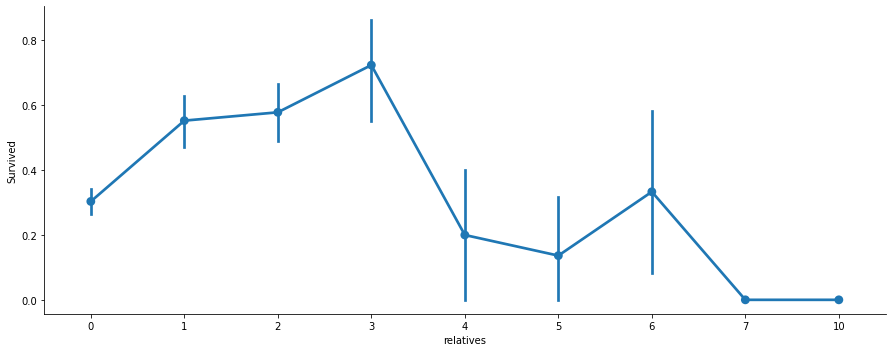

In [81]:
axes = sns.factorplot('relatives','Survived', data=df_train, aspect = 2.5, )



* SibSp (number of siblings/spouses) and Parch (number of parents/children) can be combined to one single feature: total number of relatives aboard (SibSp + Parch)
* 537 passengers are alone, while 354 passengers have relatives
* Passengers with 1 to 3 relatives have a higher suvival chance


In [82]:
print(df_train.head())

   PassengerId  Survived  Pclass  ... Embarked relatives  not_alone
0            1         0       3  ...        S         1          0
1            2         1       1  ...        C         1          0
2            3         1       3  ...        S         0          1
3            4         1       1  ...        S         1          0
4            5         0       3  ...        S         0          1

[5 rows x 14 columns]


In [83]:
df_train['Age'].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

## Data Preprocessing


In [0]:
df_train = df_train.drop(['PassengerId'], axis=1) # drop the Passenger Id from dataset
df_test = df_test.drop(['PassengerId'], axis=1)

In [85]:
print(df_train.shape)
print(df_test.shape)

(891, 13)
(418, 12)


### Deal with missing data: Cabin(687), Age(2), and Embarked(2)

* Cabin
> The letter in the cabin number, eg. 'C123' refers to the deck. Instead of deleting the Cabin column directly, we extract these letters and create a new feature that contains a passenger's deck. Then, the missing values will be represented by 0, and the letters will be converted to numeric variables.




In [0]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [df_train, df_test]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
df_train = df_train.drop(['Cabin'], axis=1)
df_test = df_test.drop(['Cabin'], axis=1)

In [87]:
print(df_train['Deck'].describe())

count    891.000000
mean       6.936027
std        2.074282
min        0.000000
25%        8.000000
50%        8.000000
75%        8.000000
max        8.000000
Name: Deck, dtype: float64


In [88]:
print(df_test['Deck'].describe())

count    418.000000
mean       6.976077
std        2.048431
min        1.000000
25%        8.000000
50%        8.000000
75%        8.000000
max        8.000000
Name: Deck, dtype: float64


* Age


> Filling in the missing values with random numbers generated based on the mean and standard deviation of the age values 



In [89]:
df_train['Age'].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

In [0]:
data = [df_train, df_test]

for dataset in data:
    mean = dataset["Age"].mean() # may use dataset instead of df_train
    std = dataset["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = df_train["Age"].astype(int)
# df_train["Age"].isnull().sum()

In [91]:
df_train["Age"].isnull().sum()

0

In [92]:
df_train['Age'].value_counts()

24    37
18    33
21    33
22    33
36    32
      ..
74     1
66     1
12     1
53     1
80     1
Name: Age, Length: 71, dtype: int64

In [93]:
df_test['Age'].value_counts()

22    21
24    20
28    18
21    16
29    16
      ..
11     1
12     1
52     1
49     1
71     1
Name: Age, Length: 62, dtype: int64

* Embarked
> Filling in the two missing value with the most common one

In [94]:
df_train['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [0]:
common_value = 'S'
data = [df_train, df_test]

for dataset in data:
  dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

### Convert features' data type

In [96]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Name       891 non-null    object 
 3   Sex        891 non-null    object 
 4   Age        891 non-null    int64  
 5   SibSp      891 non-null    int64  
 6   Parch      891 non-null    int64  
 7   Ticket     891 non-null    object 
 8   Fare       891 non-null    float64
 9   Embarked   891 non-null    object 
 10  relatives  891 non-null    int64  
 11  not_alone  891 non-null    int64  
 12  Deck       891 non-null    int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 90.6+ KB




*   Convert 3 categorical features: Name, Sex, Embarked into numeric features
*   The unique ticket number does not contribute to prediction, remove it



In [0]:
df_train = df_train.drop(['Ticket'], axis = 1)
df_test = df_test.drop(['Ticket'], axis=1)

* Fare (convert from float to int64)

In [0]:
data = [df_train, df_test]
for dataset in data:
  dataset['Fare'] = dataset['Fare'].fillna(0)
  dataset['Fare'] = dataset['Fare'].astype(int)

* Name: just extract the Name Titles, then convert it to numeric categories

In [0]:
data = [df_train, df_test]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
df_train = df_train.drop(['Name'], axis=1)
df_test = df_test.drop(['Name'], axis=1)

In [100]:
df_train['Title'].value_counts()

1    517
2    185
3    126
4     40
5     23
Name: Title, dtype: int64

* Sex (convert to number caregories)

In [0]:
genders = {"male": 0, "female": 1}
data = [df_train, df_test]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

* Embarked (convert to number categories)

In [0]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [df_train, df_test]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [103]:
df_train['Embarked'].value_counts()

0    646
1    168
2     77
Name: Embarked, dtype: int64

## Create Categories for Age and Fare

### Age
Create age groups after converting it from float to integers

In [0]:
data = [df_train, df_test]
for dataset in data:
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6


In [105]:
df_train['Age'].value_counts()

6    170
4    159
5    145
3    133
2    116
1    100
0     68
Name: Age, dtype: int64

### Fare

In [106]:
df_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title
0,0,3,0,2,1,0,7,0,1,0,8,1
1,1,1,1,5,1,0,71,1,1,0,3,3
2,1,3,1,3,0,0,7,0,0,1,8,2
3,1,1,1,5,1,0,53,0,1,0,3,3
4,0,3,0,5,0,0,8,0,0,1,8,1
5,0,3,0,6,0,0,8,2,0,1,8,1
6,0,1,0,6,0,0,51,0,0,1,5,1
7,0,3,0,0,3,1,21,0,4,0,8,4
8,1,3,1,3,0,2,11,0,2,0,8,3
9,1,2,1,1,1,0,30,1,1,0,8,3


In [0]:
data = [df_train, df_test]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

In [108]:
df_train['Fare'].value_counts()

0    241
2    223
1    216
3    158
4     44
5      9
Name: Fare, dtype: int64

In [109]:
df_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title
0,0,3,0,2,1,0,0,0,1,0,8,1
1,1,1,1,5,1,0,3,1,1,0,3,3
2,1,3,1,3,0,0,0,0,0,1,8,2
3,1,1,1,5,1,0,3,0,1,0,3,3
4,0,3,0,5,0,0,1,0,0,1,8,1
5,0,3,0,6,0,0,1,2,0,1,8,1
6,0,1,0,6,0,0,3,0,0,1,5,1
7,0,3,0,0,3,1,2,0,4,0,8,4
8,1,3,1,3,0,2,1,0,2,0,8,3
9,1,2,1,1,1,0,2,1,1,0,8,3


In [110]:
df_test.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title
0,3,0,2,0,0,0,2,0,1,8,1
1,3,1,5,1,0,0,0,1,0,8,3
2,2,0,3,0,0,1,2,0,1,8,1
3,3,0,5,0,0,1,0,0,1,8,1
4,3,1,5,1,1,1,0,2,0,8,3
5,3,0,6,0,0,1,0,0,1,8,1
6,3,1,6,0,0,0,2,0,1,8,2
7,2,0,0,1,1,2,0,2,0,8,1
8,3,1,3,0,0,0,1,0,1,8,3
9,3,0,1,2,0,2,0,2,0,8,1


## Applying Cross Validation and building the Random Forest model

In [0]:
X_train = df_train.copy(deep=True)
Y_train = df_train['Survived'].copy(deep=True)
X_test = df_test.copy(deep=True)

In [0]:
X_train = X_train.drop('Survived', axis=1)

In [113]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(891, 11)
(891,)
(418, 11)


In [114]:
print(df_train.shape)
print(df_test.shape)

(891, 12)
(418, 11)


### Calculate correlations between features

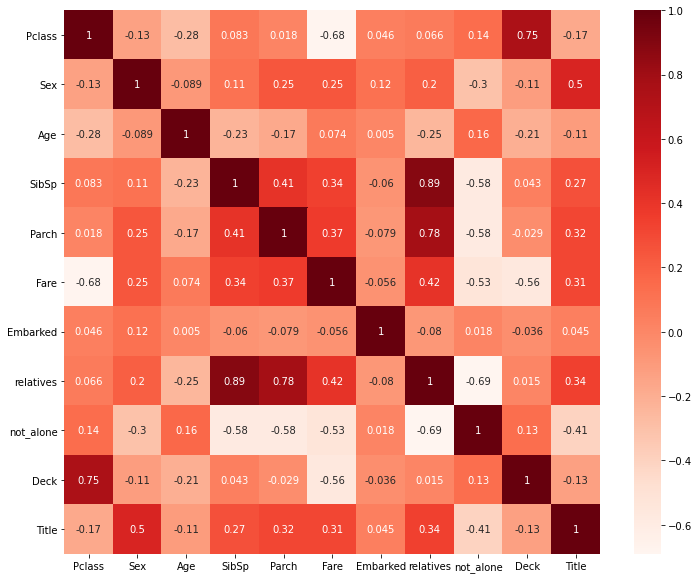

In [115]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

From the heatmap, SibSp and relatives, Parch and relatives are highly correlated, so we are going to drop them from the dataset.

In [0]:
X_train = X_train.drop('SibSp', axis=1)
X_test = X_test.drop('SibSp', axis=1)
X_train = X_train.drop('Parch', axis=1)
X_test = X_test.drop('Parch', axis=1)

In [117]:
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,relatives,not_alone,Deck,Title
0,3,0,2,0,0,1,0,8,1
1,1,1,5,3,1,1,0,3,3
2,3,1,3,0,0,0,1,8,2
3,1,1,5,3,0,1,0,3,3
4,3,0,5,1,0,0,1,8,1


Now we use X_train and X_test as the training and testing data for this project. Y_train represents the ground truth for X_train.

### Random Forest  



In [0]:
# apply Random Forest without cross validation
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

In [119]:
print("The training accuracy of the random forest model is {}%".format(acc_random_forest))

The training accuracy of the random forest model is 92.26%




*   Cross-validation



In [120]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.73333333 0.83146067 0.73033708 0.86516854 0.84269663 0.79775281
 0.83146067 0.7752809  0.83146067 0.83146067]
Mean: 0.8070411985018726
Standard Deviation: 0.04409841590962576


From the cross-validation results, the average accuracy of this model is 81.9%, while the standard deviation is 4%.



*   Feature Importance for Random Forest



In [121]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(10)

,importance
feature,
Title,0.232
Sex,0.161
Age,0.151
Pclass,0.103
Fare,0.102
relatives,0.092
Deck,0.092
Embarked,0.048
not_alone,0.019


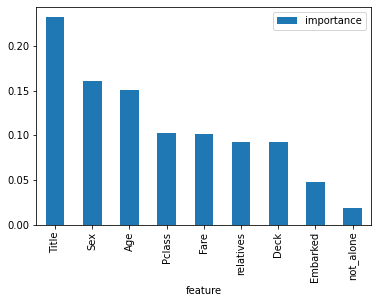

In [122]:
importances.plot.bar()

From the feature importance analysis of the random forest model, 'not-alone' has way less importance than other features. Redundancy features might cause model overfiting, so we can just remove it.

In [0]:
X_train = X_train.drop('not_alone', axis=1)
X_test = X_test.drop('not_alone', axis=1)

In [0]:
# random forest again

random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

In [125]:
print("Now, the training accuracy of the random forest model is {}%".format(acc_random_forest))

Now, the training accuracy of the random forest model is 92.26%


This model performs as good as it did before. More features make the model more likely to suffer from overfitting. Therefore, it will be better to drop the redundant features.

Using out-of-bag samples to estimate generalization accuracy is a more accurate way to evaluate a random forest classifier.

In [126]:
print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 80.92 %




*   Tuning parameters



In [0]:
# param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10], "n_estimators": [100]}
# from sklearn.model_selection import GridSearchCV, cross_val_score
# rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
# clf_tuned = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
# clf_tuned.fit(X_train, Y_train)

In [0]:
# clf_tuned.best_params_

* Using the tuned parameters

In [129]:
# Random Forest
random_forest_final = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest_final.fit(X_train, Y_train)
Y_prediction = random_forest_final.predict(X_test)

random_forest_final.score(X_train, Y_train)

print("oob score:", round(random_forest_final.oob_score_, 4)*100, "%")

oob score: 82.38 %


In [130]:
test_sample = X_test.head(1)
test_sample

,Pclass,Sex,Age,Fare,Embarked,relatives,Deck,Title
0,3,0,2,0,2,0,8,1


In [131]:
test_sample_prediction = random_forest_final.predict(test_sample)
test_sample_prediction

array([0])

## JSON workflow
Useful for debugging Flask apps

In [132]:
json_payload = test_sample.to_json()
json_payload

'{"Pclass":{"0":3},"Sex":{"0":0},"Age":{"0":2},"Fare":{"0":0},"Embarked":{"0":2},"relatives":{"0":0},"Deck":{"0":8},"Title":{"0":1}}'

## Pickling sklearn model

In [0]:
from sklearn.externals import joblib

In [134]:
joblib.dump(random_forest_final, 'Titanic_prediction_updated.joblib')

['Titanic_prediction_updated.joblib']

In [135]:
!ls -l

total 2600
drwxr-xr-x 1 root root    4096 Apr  3 16:24 sample_data
-rw-r--r-- 1 root root 1327730 Apr 28 16:19 Titanic_prediction.joblib
-rw-r--r-- 1 root root 1324274 Apr 28 16:20 Titanic_prediction_updated.joblib


## Unpickle and predict

In [0]:
clf = joblib.load('Titanic_prediction_updated.joblib')

In [137]:
test_sample2 = X_test.head(5)
test_sample2

,Pclass,Sex,Age,Fare,Embarked,relatives,Deck,Title
0,3,0,2,0,2,0,8,1
1,3,1,5,0,0,1,8,3
2,2,0,3,1,2,0,8,1
3,3,0,5,1,0,0,8,1
4,3,1,5,1,0,2,8,3


In [138]:
# Use pickle loaded model
list(clf.predict(test_sample2))

[0, 0, 0, 0, 0]

In [139]:
train_sample2 = X_train.head(5)
train_sample2

,Pclass,Sex,Age,Fare,Embarked,relatives,Deck,Title
0,3,0,2,0,0,1,8,1
1,1,1,5,3,1,1,3,3
2,3,1,3,0,0,0,8,2
3,1,1,5,3,0,1,3,3
4,3,0,5,1,0,0,8,1


In [140]:
list(clf.predict(train_sample2)) # This are the predicted results

[0, 1, 1, 1, 0]

In [141]:
Y_train.head(5) # This is the ground truth

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

### Reference
https://www.kaggle.com/c/titanic/data  
https://medium.com/@raghav96_77243/exploring-the-titanic-dataset-68e50263c14d   
https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8  
https://towardsdatascience.com/understanding-random-forest-58381e0602d2